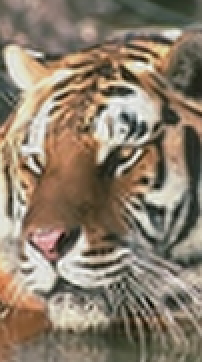

In [22]:
using Images,Distributions, JLD

test_image = "/Users/manvithaponnapati/RAISR/test_data/interpolated/test_image_2.jpg"
test_im = load(test_image)

In [23]:
@everywhere function hashkey(patch,weights_matrix,patchsize)
    gx,gy = imgradients(patch,KernelFactors.ando3)
    gx = reshape(gx,patchsize*patchsize,1)
    gy = reshape(gy,patchsize*patchsize,1)
    GT = transpose([gx gy])
   
    GTWG = GT*weights_matrix*transpose(GT)
    
    eigen_max = eigmax(GTWG)
    eigen_min = eigmin(GTWG)
    eigen_vector_max = eigvecs(GTWG)[:,1]
    eigen_vector_min = eigvecs(GTWG)[:,2]
    gradient_angle = atan2(eigen_vector_max[2],eigen_vector_max[1])
    if gradient_angle < 0
        gradient_angle = gradient_angle + pi
    end
    lamda = abs(sqrt(complex(eigen_max)))/Qstrength
    u =(sqrt(complex(eigen_max)) -  sqrt(complex(eigen_min)))/(sqrt(complex(eigen_max)) +  sqrt(complex(eigen_min)))/Qcoherence
    angle = floor(gradient_angle/pi*Qangle)

    if lamda < 0.0001
        strength = 1
    elseif lamda > 0.001
        strength = 3
    else
        strength = 2
    end

    u = abs(u)
    if u < 0.25
        coherence = 1
    elseif u > 0.5
        coherence = 3
    else
        coherence = 2
    end


    # Bound the output to the desired ranges
    if angle > 23
        angle = 23
    elseif angle <= 0
        angle = 1
    end
    angle = Int(angle)
    return angle,strength,coherence
end

In [24]:
learned_filters = load("learned_filters_59_partial.jld","filters")

24×3×3×4×25 Array{Float64,5}:
[:, :, 1, 1, 1] =
 0.00159992  0.0016021   0.00159613
 0.00159728  0.00160217  0.00159371
 0.00160067  0.00160143  0.00159406
 0.00159899  0.00160124  0.00159319
 0.00160042  0.00160119  0.00159525
 0.00160187  0.0016015   0.001595  
 0.00157404  0.00160176  0.00159416
 0.00159941  0.00160259  0.00159384
 0.00159941  0.001601    0.00159402
 0.00160025  0.00160127  0.00159407
 0.0016041   0.00160354  0.00159943
 0.00160642  0.00160318  0.00160147
 0.00159958  0.00160184  0.0015939 
 0.00160447  0.00160217  0.00159308
 0.00160043  0.00160198  0.00159391
 0.00160021  0.00160079  0.00159545
 0.00161362  0.00160198  0.00159309
 0.00159903  0.00160155  0.00159372
 0.00160075  0.00160055  0.00159376
 0.00160276  0.00160224  0.00159412
 0.00159984  0.00160139  0.00159289
 0.00160092  0.00160134  0.00159406
 0.00159807  0.00160219  0.00159599
 0.0         0.0         0.0       

[:, :, 2, 1, 1] =
 0.00160018  0.00160087  0.00158549
 0.00160023  0.00160163  0.001592

In [25]:
Qangle = 24
Qstrength = 3
Qcoherence = 3
patchsize = 5
gradientsize = 9
scaling_factor = 2
Q = zeros((Qangle, Qstrength, Qcoherence, scaling_factor*scaling_factor, patchsize*patchsize, patchsize*patchsize))
V = zeros((Qangle, Qstrength, Qcoherence, scaling_factor*scaling_factor, patchsize*patchsize))
start_index = Int(ceil(patchsize/2))
weights_matrix = load("learned_filters_59_partial.jld","weights")
scaling_factor = 2
w,h = size(test_im)
rescaled_img = rand(RGB{N0f8}, scaling_factor*w,scaling_factor*h)
for row in 1:scaling_factor*w
    for col in 1:scaling_factor*h
        rescaled_img[row,col] = bilinear_interpolation(test_im,row/scaling_factor,col/scaling_factor)
    end
end
size(rescaled_img)
colorviewRGB = channelview(rescaled_img)
ycbcr = channelview(YCbCr.(rescaled_img))
c,w,h = size(ycbcr)
upscaledHR = zeros(3,w,h)
color_ve = ycbcr[1,:,:]/255 #Luminance

724×404 Array{Float32,2}:
 0.143047  0.223348  0.223348  0.223348  …  0.225854  0.225854  0.225854
 0.223348  0.383366  0.383366  0.383366     0.388963  0.388963  0.388963
 0.223348  0.383366  0.383366  0.383366     0.388963  0.388963  0.388963
 0.223348  0.383366  0.383366  0.383366     0.388963  0.388963  0.388963
 0.221371  0.379998  0.379998  0.379998     0.379829  0.379829  0.379829
 0.221371  0.379998  0.379998  0.379998  …  0.369726  0.369726  0.369726
 0.221371  0.379998  0.379998  0.379998     0.369726  0.369726  0.369726
 0.221371  0.379998  0.379998  0.379998     0.369726  0.369726  0.369726
 0.220364  0.377984  0.377984  0.377984     0.371703  0.371703  0.371703
 0.219357  0.376593  0.376593  0.376593     0.373296  0.373296  0.373296
 0.219357  0.376593  0.376593  0.376593  …  0.373296  0.373296  0.373296
 0.219357  0.376593  0.376593  0.376593     0.373296  0.373296  0.373296
 0.218974  0.375202  0.375202  0.375202     0.37465   0.37465   0.37465 
 ⋮                       

In [26]:
@time for row in start_index:Int(w)-start_index
    for col in start_index:Int(h)-start_index
        patch = ycbcr[1,row-2:row+2,col-2:col+2]
        gradientpatch = ycbcr[1,row-1:row+1,col-1:col+1]
        angle,strength,coherence = hashkey(gradientpatch,weights_matrix,3)
        pixeltype = ((row-start_index) % scaling_factor) * scaling_factor + ((col-start_index) % scaling_factor)
        patch_ravel = reshape(patch,patchsize*patchsize)
        upscaledHR[1,row,col] = (transpose(patch_ravel)*(learned_filters[angle,strength,coherence,pixeltype+1,:]))
    end
end

 14.749206 seconds (73.61 M allocations: 12.139 GiB, 16.28% gc time)


In [27]:
rmin = minimum(upscaledHR[1,:,:])
rmax = maximum(upscaledHR[1,:,:])

xGR = round.((upscaledHR[1,:,:] -rmin) * (255 / rmax));
xGR

724×404 Array{Float64,2}:
 0.0  0.0    0.0    0.0    0.0    0.0  …    0.0    0.0    0.0  0.0  0.0  0.0
 0.0  0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0  0.0  0.0  0.0
 0.0  0.0   94.0  102.0  104.0  106.0      97.0   97.0   98.0  0.0  0.0  0.0
 0.0  0.0  101.0  112.0  114.0  116.0     104.0  106.0  107.0  0.0  0.0  0.0
 0.0  0.0  101.0  112.0  113.0  115.0     103.0  105.0  106.0  0.0  0.0  0.0
 0.0  0.0  101.0  111.0  112.0  114.0  …  102.0  103.0  105.0  0.0  0.0  0.0
 0.0  0.0  101.0  110.0  111.0  112.0     102.0  102.0  104.0  0.0  0.0  0.0
 0.0  0.0  100.0  110.0  111.0  112.0     100.0  102.0  103.0  0.0  0.0  0.0
 0.0  0.0  100.0  110.0  110.0  111.0     101.0  102.0  104.0  0.0  0.0  0.0
 0.0  0.0   99.0  109.0  110.0  110.0     101.0  102.0  104.0  0.0  0.0  0.0
 0.0  0.0  100.0  108.0  108.0  109.0  …  101.0  102.0  104.0  0.0  0.0  0.0
 0.0  0.0   99.0  108.0  108.0  108.0     101.0  102.0  104.0  0.0  0.0  0.0
 0.0  0.0   98.0  108.0  108.0  108.0     101.0  1

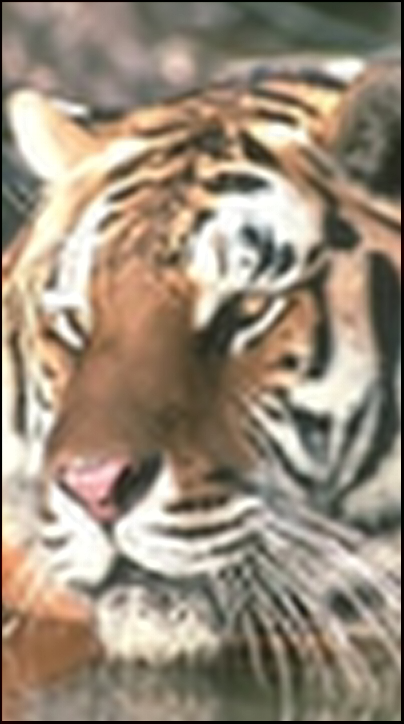

In [8]:
# Download Images from Ec2 Instance - Shut down instance
rupscaledHR = colorview(YCbCr,xGR,ycbcr[2,:,:],ycbcr[3,:,:])
# load("/Users/manvithaponnapati/RAISR/test_data/test_image_2.jpg")


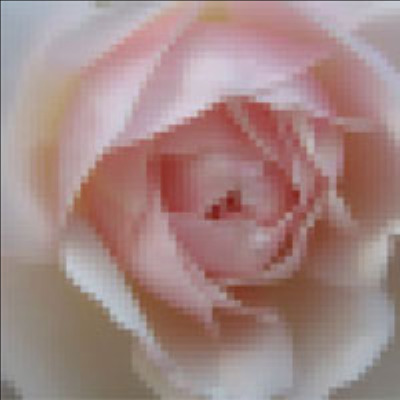

In [28]:
test_image = "/Users/manvithaponnapati/RAISR/test_data/interpolated/pixelrose.jpg"
test_im = load(test_image)

In [29]:
Qangle = 24
Qstrength = 3
Qcoherence = 3
patchsize = 5
gradientsize = 9
scaling_factor = 2
Q = zeros((Qangle, Qstrength, Qcoherence, scaling_factor*scaling_factor, patchsize*patchsize, patchsize*patchsize))
V = zeros((Qangle, Qstrength, Qcoherence, scaling_factor*scaling_factor, patchsize*patchsize))
start_index = Int(ceil(patchsize/2))
weights_matrix = load("learned_filters_59_partial.jld","weights")
scaling_factor = 2
w,h = size(test_im)
rescaled_img = rand(RGB{N0f8}, scaling_factor*w,scaling_factor*h)
for row in 1:scaling_factor*w
    for col in 1:scaling_factor*h
        rescaled_img[row,col] = bilinear_interpolation(test_im,row/scaling_factor,col/scaling_factor)
    end
end
size(rescaled_img)
colorviewRGB = channelview(rescaled_img)
ycbcr = channelview(YCbCr.(rescaled_img))
c,w,h = size(ycbcr)
upscaledHR = zeros(3,w,h)
color_ve = ycbcr[1,:,:]/255 #Luminance

800×800 Array{Float32,2}:
 0.0991693  0.13521   0.181354  0.22413   …  0.234655  0.234655  0.234655
 0.13521    0.210658  0.299962  0.385899     0.405941  0.405941  0.405941
 0.181354   0.300969  0.413849  0.526729     0.579683  0.579683  0.579683
 0.225521   0.389303  0.52812   0.665966     0.752838  0.752838  0.752838
 0.215801   0.368857  0.516807  0.663366     0.748847  0.748847  0.748847
 0.208442   0.351778  0.50608   0.662743  …  0.745863  0.745863  0.745863
 0.214794   0.363859  0.513786  0.66472      0.739128  0.739128  0.739128
 0.220523   0.376323  0.522499  0.666074     0.732392  0.732392  0.732392
 0.217155   0.369204  0.515763  0.662706     0.73576   0.73576   0.73576 
 0.213403   0.362084  0.511004  0.658954     0.739128  0.739128  0.739128
 0.210419   0.358716  0.509027  0.659961  …  0.73576   0.73576   0.73576 
 0.208058   0.355348  0.509027  0.662322     0.733399  0.733399  0.733399
 0.212817   0.363859  0.513786  0.666697     0.733015  0.733015  0.733015
 ⋮          

In [30]:
@time for row in start_index:Int(w)-start_index
    for col in start_index:Int(h)-start_index
        patch = ycbcr[1,row-2:row+2,col-2:col+2]
        gradientpatch = ycbcr[1,row-1:row+1,col-1:col+1]
        angle,strength,coherence = hashkey(gradientpatch,weights_matrix,3)
        pixeltype = ((row-start_index) % scaling_factor) * scaling_factor + ((col-start_index) % scaling_factor)
        patch_ravel = reshape(patch,patchsize*patchsize)
        upscaledHR[1,row,col] = (transpose(patch_ravel)*(learned_filters[angle,strength,coherence,pixeltype+1,:]))
    end
end

 42.570979 seconds (164.58 M allocations: 26.784 GiB, 14.55% gc time)


In [31]:
rmin = minimum(upscaledHR[1,:,:])
rmax = maximum(upscaledHR[1,:,:])

xGR = round.((upscaledHR[1,:,:] -rmin) * (255 / rmax));
xGR

800×800 Array{Float64,2}:
 0.0  0.0    0.0    0.0    0.0    0.0  …    0.0    0.0    0.0  0.0  0.0  0.0
 0.0  0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0  0.0  0.0  0.0
 0.0  0.0  121.0  140.0  154.0  160.0     179.0  180.0  179.0  0.0  0.0  0.0
 0.0  0.0  141.0  166.0  182.0  191.0     213.0  213.0  213.0  0.0  0.0  0.0
 0.0  0.0  154.0  182.0  202.0  211.0     235.0  235.0  235.0  0.0  0.0  0.0
 0.0  0.0  160.0  190.0  210.0  219.0  …  245.0  245.0  245.0  0.0  0.0  0.0
 0.0  0.0  159.0  188.0  208.0  217.0     244.0  244.0  244.0  0.0  0.0  0.0
 0.0  0.0  159.0  188.0  207.0  216.0     243.0  244.0  243.0  0.0  0.0  0.0
 0.0  0.0  159.0  187.0  208.0  215.0     243.0  243.0  243.0  0.0  0.0  0.0
 0.0  0.0  158.0  187.0  207.0  215.0     242.0  243.0  242.0  0.0  0.0  0.0
 0.0  0.0  158.0  187.0  207.0  215.0  …  242.0  243.0  242.0  0.0  0.0  0.0
 0.0  0.0  158.0  187.0  207.0  215.0     242.0  242.0  242.0  0.0  0.0  0.0
 0.0  0.0  158.0  187.0  206.0  215.0     242.0  2

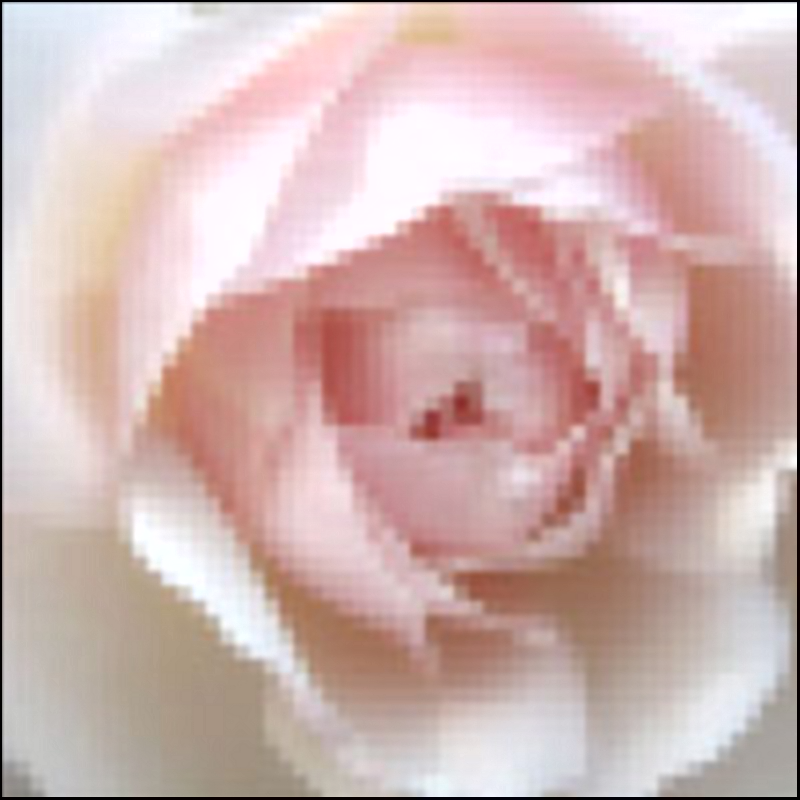

In [32]:
# Download Images from Ec2 Instance - Shut down instance
rupscaledHR = colorview(YCbCr,xGR,ycbcr[2,:,:],ycbcr[3,:,:])
# load("/Users/manvithaponnapati/RAISR/test_data/test_image_2.jpg")


In [ ]:
test_image = "/Users/manvithaponnapati/RAISR/test_data/low_res/144067.jpg"
test_im = load(test_image)

In [ ]:
Qangle = 24
Qstrength = 3
Qcoherence = 3
patchsize = 5
gradientsize = 9
scaling_factor = 2
Q = zeros((Qangle, Qstrength, Qcoherence, scaling_factor*scaling_factor, patchsize*patchsize, patchsize*patchsize))
V = zeros((Qangle, Qstrength, Qcoherence, scaling_factor*scaling_factor, patchsize*patchsize))
start_index = Int(ceil(patchsize/2))
weights_matrix = load("learned_filters_59_partial.jld","weights")
scaling_factor = 2
w,h = size(test_im)
rescaled_img = rand(RGB{N0f8}, scaling_factor*w,scaling_factor*h)
for row in 1:scaling_factor*w
    for col in 1:scaling_factor*h
        rescaled_img[row,col] = bilinear_interpolation(test_im,row/scaling_factor,col/scaling_factor)
    end
end
size(rescaled_img)
colorviewRGB = channelview(rescaled_img)
ycbcr = channelview(YCbCr.(rescaled_img))
c,w,h = size(ycbcr)
upscaledHR = zeros(3,w,h)
color_ve = ycbcr[1,:,:]/255 #Luminance